In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
import json

def load_from_disk(name):
    try:
        with open(name, 'r') as f:
            tree = json.load(f)
            return tree
    except:
        return None

In [2]:
lbl2word = load_from_disk("generated/lbl2word.json")
word2lbl = load_from_disk("generated/word2lbl.json")
symbol2name = load_from_disk("generated/symbol2name.json")
name2symbol = load_from_disk("generated/name2symbol.json")

In [3]:
expcheb = pd.read_csv("generated/expcheb.csv")

In [4]:
expcheb.head()

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,Arabs,Founding year,Current type of locality,Organizational affiliation,Coordinates,height,Planning Commission,Police space,year,Cluster Local Authorities
0,Tirosh,10,333,237,2,235,3,0,0,0,...,0.0,1955,310,2.0,1.892863e+09,130.0,151.0,15000597.0,2018,0.0
1,Mevasseret Ziyyon,1015,18871,13883,37,13846,81,2,0,2,...,98.0,1951,160,0.0,2.144363e+09,583.0,152.0,10002475.0,2018,0.0
2,Me'ir Shefeya,102,106,54,0,54,0,0,0,0,...,38.0,1923,340,0.0,1.975772e+09,63.0,303.0,10004333.0,2018,0.0
3,Or Aqiva,1020,15520,9773,72,9701,119,0,0,0,...,93.0,1951,170,0.0,1.927371e+09,10.0,353.0,10004261.0,2018,0.0
4,Haruzim,1024,584,442,3,439,3,0,0,0,...,0.0,1951,350,0.0,1.874468e+09,39.0,401.0,15000060.0,2018,0.0


In [5]:
expcheb2 = pd.read_csv("generated/expcheb2.csv")

In [6]:
expcheb3 = pd.read_csv("generated/expcheb3.csv")

In [7]:
data = expcheb.append(expcheb2, ignore_index=True)

In [8]:
del expcheb2
del expcheb

In [9]:
def drop_cols(data):
    cols = ["sName", "voters", "valid", "droped", "subdistrict", "Natural area", "Metropolitan affiliation", "Founding year", "Organizational affiliation", "Coordinates", "height", "Planning Commission", "Police space", "year", "Cluster Local Authorities"]
    for col in cols:
        data = data.drop(col, axis=1)
        
    return data

In [10]:
train_label = data["droped"]
data = drop_cols(data)
test_label = expcheb3["droped"]
expcheb3 = drop_cols(expcheb3)

In [11]:
RSEED = 50

In [12]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, cv = 5, 
                        n_iter = 1, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(data, train_label)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [13]:
rs.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [14]:
best_model = rs.best_estimator_

In [15]:
rf_predictions = best_model.predict(expcheb3)
metrics.mean_squared_error(rf_predictions, test_label)

257.5290294804997

In [16]:
df = pd.DataFrame({"Predictions":rf_predictions})
names = [symbol2name[str(value)] for value in expcheb3["sSymbol"]]
df.insert(0,"sName", names)
df = df.sort_values('Predictions', ascending = False)
df.head(10)

,sName,Predictions
493,Jerusalem,1673.154036
196,Bene Beraq,1110.827480
1187,Tel Aviv - Yafo,1034.688012
405,Haifa,843.813722
114,Ashdod,818.676496
859,Netanya,802.539881
129,Be'er Sheva,779.311317
1056,Rishon LeZiyyon,759.292127
987,Petah Tiqwa,754.748198
392,Holon,658.630841


In [17]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [18]:
Avg = rf_predictions.mean(axis=0)
rfc_train_label = train_label > Avg
rfc_train_label = rfc_train_label.astype(int)
rfc_test_label = rf_predictions > Avg
rfc_test_label = rfc_test_label.astype(int)

In [19]:
rfc_test_label

array([0, 1, 1, ..., 0, 0, 0])

In [22]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state = RSEED)
rs = GridSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5, verbose = 1)
rs.fit(data, rfc_train_label)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=50,
                                  

In [23]:
rs.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [24]:
best_model = rs.best_estimator_

In [25]:
rfc_predictions = best_model.predict(expcheb3)
print("Predictions: ", rfc_predictions)
print('Accuracy:', metrics.accuracy_score(rfc_test_label, rfc_predictions))

Predictions:  [0 1 1 ... 0 0 0]
Accuracy: 0.9925742574257426


Confusion matrix, without normalization
[[1060    3]
 [   6  143]]


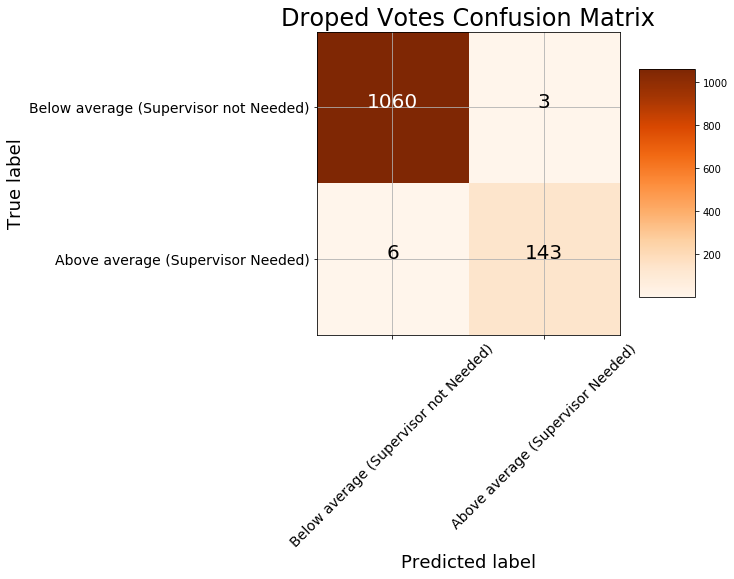

In [27]:
matrix = confusion_matrix(rfc_test_label, rfc_predictions)
plot_confusion_matrix(matrix, classes = ['Below average (Supervisor not Needed)', 'Above average (Supervisor Needed)'],
                      title = 'Droped Votes Confusion Matrix')

In [30]:
df = pd.DataFrame({"Supervisor needed":rfc_predictions})
names = [symbol2name[str(value)] for value in expcheb3["sSymbol"]]
df.insert(0,"sName", names)
df

,sName,Supervisor needed
0,Abu Juway'ad,0
1,Abu Ghosh,1
2,Abu Sinan,1
3,Abu 'Abdun,0
4,Abu Kuraynat,0
...,...,...
1207,Tequma,0
1208,Teqoa,0
1209,Tarabin as-Sani',0
1210,Tarabin As-Sani,0


<Figure size 432x288 with 0 Axes>

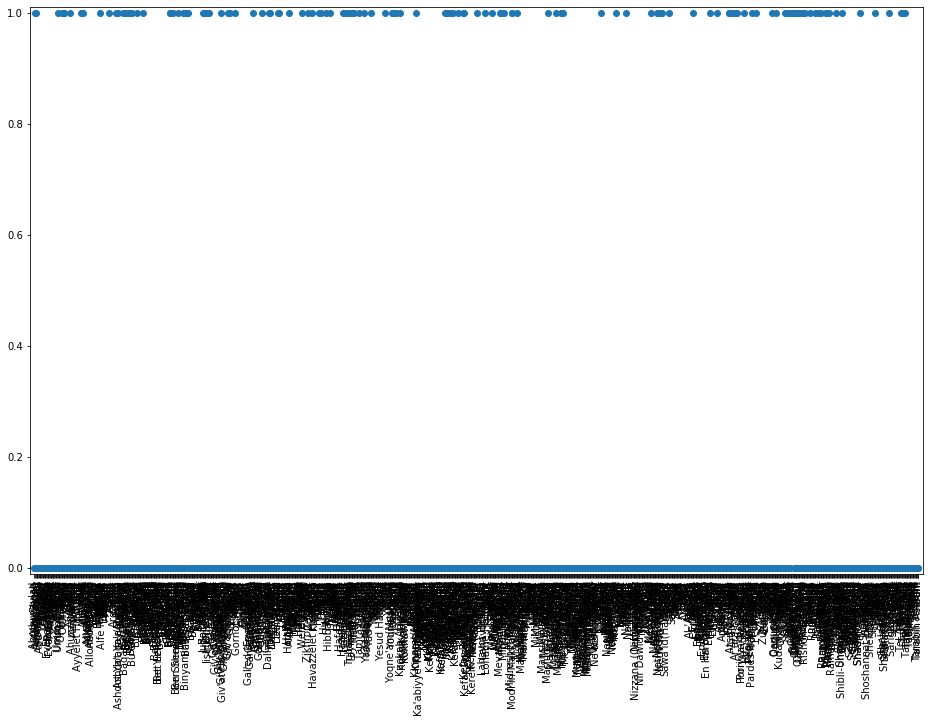

In [46]:
plt.figure(0)
plt.figure(figsize=(16,9))
plt.scatter(df["sName"], rfc_predictions)
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(df["sName"], df["sName"], rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.005)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.005)
plt.show()